In [16]:
import matplotlib.ticker as mticker
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from matplotlib.transforms import Bbox

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern

cmaps = plt.get_cmap("Dark2")
mpl.rcParams['font.weight']='normal'

mpl.rcParams['font.size']=16 #10 #16 pour posts
mpl.rcParams['legend.fontsize']=12 #10 12 pour posts



In [7]:
#likelihood_study
t1=pd.DataFrame(data=np.loadtxt("results/ll.gnu"),columns=['s','l','ll'])
t2=pd.DataFrame(data=np.loadtxt("results/ll_linear.gnu"),columns=['s','l','ll'])
print(t1)
a=int(np.sqrt(len(t1)))
print(a)

             s         l        ll
0       1.0000   1.00000  150.0960
1       1.0000   1.02329  150.4040
2       1.0000   1.04713  150.5990
3       1.0000   1.07152  150.6760
4       1.0000   1.09648  150.6340
...        ...       ...       ...
39995  19.7027  89.12510   25.9590
39996  19.7027  91.20110   29.4950
39997  19.7027  93.32540   33.0065
39998  19.7027  95.49930   36.4928
39999  19.7027  97.72370   39.9533

[40000 rows x 3 columns]
200


In [49]:
def plot_gpr_samples(gpr_model, n_samples,ax2,ls,kernelname):
    x = np.linspace(0, 5, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples,random_state=gpr_model.random_state)
    color_list=cmaps.colors
    for idx, single_prior in enumerate(y_samples.T):
        ax2.plot(
            x,
            single_prior,
            linestyle="-",
            alpha=1,
            label=f"Sampled function #{idx + 1}",
            color=color_list[idx]
        )
    ax2.plot(x, y_mean, color="black",linestyle="--",alpha=0.6)
    ax2.plot(x, y_mean-y_std, color="black",linestyle="--",alpha=0.3)
    ax2.plot(x, y_mean+y_std, color="black",linestyle="--",alpha=0.3)
    #ax2.fill_between(x,y_mean - y_std,y_mean + y_std,alpha=0.1,color="black",label=r"$\pm$ 1 std. dev.", )
    ax2.set_xlabel("x")
    #ax2.set_ylabel("GP(x)")
    ax2.set_xlim([0, 5])
    ax2.set_ylim([-10, 10])

    print()
rs=np.random.RandomState(68436697)

def setlabel(ax, label, loc=2, borderpad=0.6, **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN,np.NaN,color='none',label=label)
    label_legend = ax.legend(handles=[line],loc=loc,handlelength=0,handleheight=0,handletextpad=0,borderaxespad=0,borderpad=borderpad,frameon=False,**kwargs)
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()

168.567





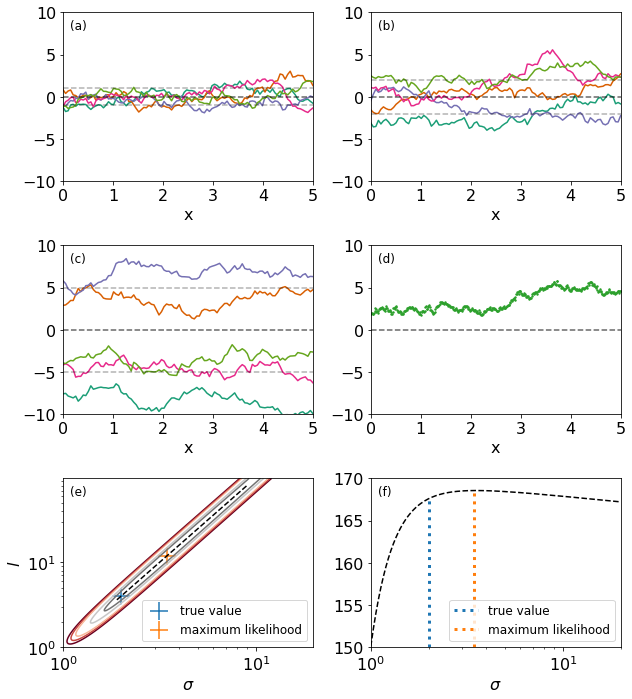

In [53]:

#X,Y=np.meshgrid(t1['sedm'],t1['l'])
obs=pd.DataFrame(data=np.loadtxt("results/observations.gnu"),columns=['x','obs'])
x=t1['s']
y=t1['l']
z1=t1['ll']

cmap='RdGy'
nsteps=7
probstep=15

print(np.max(z1))

Z1=np.reshape(np.array(z1),(-1,a),order='F')

x=np.unique(np.array(x))
y=np.unique(np.array(y))
X,Y=np.meshgrid(x,y)


fig,((axgp1,axgp2),(axgp3,ax2),(ax1,ax3))=plt.subplots(nrows=3,ncols=2,figsize=(9,10))
levels = np.linspace(np.max(z1)-probstep, np.max(z1), nsteps)
c=ax1.contour(X, Y, Z1,cmap=cmap,levels=levels)
#plt.colorbar(c,ax=ax1)
ax1.set_xlabel(r'$\sigma$')
ax1.set_ylabel(r'$l$')
#ax1.set_title(r'log p$(y|\sigma,l)$')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())


#plot de la pente qui doit être de 3.
X=np.linspace(1.9,9,1000)
Y=np.power(X,2)
maxpoint=t2.sort_values('ll',ascending=False).head(1)
mp=[maxpoint['s'],maxpoint['l']]
ax1.plot(X,Y,ls='dashed',color='black')
ax1.scatter(2,4,marker='+',s=300,color='tab:blue',label='true value')
ax1.scatter(mp[0],mp[1],marker='+',s=300,color='tab:orange',label='maximum likelihood')
ax1.legend(loc='lower right')

ax2.scatter(obs['x'],obs['obs'],s=2,color='tab:green')
ax2.set_xlim([0,5])
ax2.set_ylim([-10,10])
ax2.set_xlabel('x')
#ax2.set_title('observations')
ax2.plot(obs['x'], np.zeros(len(obs['x'])), color="black",linestyle="--",alpha=0.6)

ax3.plot(t2['s'],t2['ll'],color='black',linestyle='dashed')
ax3.set_xscale('log')
ax3.set_xlabel(r'$\sigma$')
#ax3.set_title(r'log p$(y|\sigma,l)$ with $l=\sigma^2$')
ax3.vlines(2,150,167.7,color='tab:blue',label='true value',linestyle='dotted',lw=3)
ax3.vlines(mp[0],150,168.6,color='tab:orange',label='maximum likelihood',linestyle='dotted',lw=3)
ax3.set_xlim([1,20])
ax3.set_ylim([150,170])
ax3.legend(loc='lower right')


##plot les trajectoires des noyaux
sigma=[1,2,5]
l=[1,4,25]
nu=0.5
k1=sigma[0]**2*Matern(length_scale=l[0],nu=nu)
k2=sigma[1]**2*Matern(length_scale=l[1],nu=nu)
k3=sigma[2]**2*Matern(length_scale=l[2],nu=nu)
gpr1=GaussianProcessRegressor(kernel=k1, random_state=rs)
gpr2=GaussianProcessRegressor(kernel=k2, random_state=rs)
gpr3=GaussianProcessRegressor(kernel=k3, random_state=rs)
plot_gpr_samples(gpr1,5,axgp1,'-','ok')
plot_gpr_samples(gpr2,5,axgp2,'-','ok')
plot_gpr_samples(gpr3,5,axgp3,'-','ok')

#labels
setlabel(axgp1, '(a)')
setlabel(axgp2, '(b)')
setlabel(axgp3, '(c)')
setlabel(ax2, '(d)')
setlabel(ax1, '(e)')
setlabel(ax3, '(f)')


plt.tight_layout()
fig.savefig('exmatern.png')


(-10.0, 10.0)

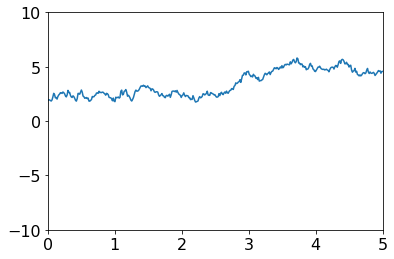

In [4]:
#affichage de la trajectoire pour être sûr
fig,ax1=plt.subplots(nrows=1,ncols=1,figsize=(6,4))
ax1.plot(obs['x'],obs['obs'])
ax1.set_xlim([0,5])
ax1.set_ylim([-10,10])
